In [27]:
import numpy as np
import os,glob,struct,shutil,copy
import xarray as xr
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [28]:
from parflow import Run, read_pfb, write_pfb, ParflowBinaryReader,read_pfb_sequence

In [29]:
root_dir = "/home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/"

Change some input files:

In [30]:
with ParflowBinaryReader(root_dir+'perm1.pfb') as pfb:
    data = pfb.read_all_subgrids()
    hdr = pfb.read_header()

conversion m/h -> m/min

In [31]:
data = data/60

In [32]:
# tests:::
# all with 
#SA_mil_1.Geom.H2.RelPerm.Alpha = 1.5
#SA_mil_1.Geom.H2.RelPerm.N = 1.7
#and
#SA_mil_1.Geom.H3.RelPerm.Alpha = 1.84
#SA_mil_1.Geom.H3.RelPerm.N = 2.35

#data = data*0.0 + 5.55*10**-7
# testé: 12% de Ke !
# data = data[::-1,:,:]
# testé, ne change rien, Ke = 12%
#data[-8:-5,:,:] = data[-1,0,0]
# testé, Ke=12%
#data[-6:-5,:,:] = data[-1,0,0]
# testé, Ke = 10.5%
data[-11:-5,:,:] = 0.01/60
# test, ne change rien (Ke = 0)

# le dernier test: Kr=18% avec
#SA_mil_1.Geom.H2.RelPerm.Alpha =5
#SA_mil_1.Geom.H2.RelPerm.N = 3
#et
#SA_mil_1.Geom.H3.RelPerm.Alpha =5
#SA_mil_1.Geom.H3.RelPerm.N = 3


# 1mn ->19.01%

In [8]:
write_pfb(root_dir+'perm1s.pfb',data,**hdr)

In [34]:
data[:,0,0]

array([4.20000000e-03, 4.20000000e-03, 4.20000000e-03, 4.20000000e-03,
       4.20000000e-03, 4.20000000e-03, 4.20000000e-03, 4.20000000e-03,
       4.20000000e-03, 4.20000000e-03, 4.20000000e-03, 4.20000000e-03,
       4.20000000e-03, 3.00000000e-03, 3.00000000e-03, 3.00000000e-03,
       3.00000000e-03, 3.00000000e-03, 3.00000000e-03, 1.66666667e-04,
       1.66666667e-04, 1.66666667e-04, 1.66666667e-04, 1.66666667e-04,
       1.66666667e-04, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05])

## correct LAI, SAI... remove bare soil time series

In [9]:
#lai = pd.read_csv(root_dir+'../data_2D/lai_2006_2009_5min.dat',header=None,sep=' ')
#lai[17] = 0.
#lai.to_csv(root_dir+'../data_2D/lai_2006_2009_5min_sn.dat',float_format='%2.4f', sep=' ', header=False, index=False)

#sai = pd.read_csv(root_dir+'../data_2D/sai_2006_2009_5min.dat',header=None,sep=' ')
#sai[17] = 0.
#sai.to_csv(root_dir+'../data_2D/sai_2006_2009_5min_sn.dat',float_format='%2.4f', sep=' ', header=False, index=False)

#z0m = pd.read_csv(root_dir+'../data_2D/zom_2006_2009_5min.dat',header=None,sep=' ')
#z0m[17] = 0.01
#z0m.to_csv(root_dir+'../data_2D/z0m_2006_2009_5min_sn.dat',float_format='%2.4f', sep=' ', header=False, index=False)

#displa = pd.read_csv(root_dir+'../data_2D/displa_2006_2009_5min.dat',header=None,sep=' ')
#displa[17] = 0.
#displa.to_csv(root_dir+'../data_2D/displa_2006_2009_5min_sn.dat',float_format='%2.4f', sep=' ', header=False, index=False)

Verification

### Extract rainfall events

Read forcings

In [15]:
""" Read Forcings: """
forcing_headers = {0:'SWin',1:'LWin',2:'P', 3: 'T', 4:'WindX', 5:'WindY',6:'Press', 7:'Hs'}
forc = pd.read_csv(os.sep.join([root_dir,'forc_bani_5min_2006_2009.txt']),header=None,sep=' ')
forc.rename(columns=forcing_headers,inplace=True)
forc.index=pd.date_range('1/1/2006 00:00:00', periods=len(forc), freq='5min')
P=forc['P']*5*60
forc

SWin      LWin    P         T   WindX  WindY    Press  \
2006-01-01 00:00:00  3.7305  316.1700  0.0  291.1000  0.9565    0.0  98450.0   
2006-01-01 00:05:00  3.7260  316.3100  0.0  291.0508  0.9113    0.0  98450.0   
2006-01-01 00:10:00  3.7215  316.4500  0.0  291.0017  0.8660    0.0  98450.0   
2006-01-01 00:15:00  3.7170  316.5900  0.0  290.9525  0.8208    0.0  98450.0   
2006-01-01 00:20:00  3.7125  316.7300  0.0  290.9033  0.7755    0.0  98450.0   
...                     ...       ...  ...       ...     ...    ...      ...   
2009-12-31 23:10:00 -0.2190  318.3567  0.0  292.3033  0.2318    0.0  98750.0   
2009-12-31 23:15:00 -0.2070  318.2350  0.0  292.1475  0.1910    0.0  98750.0   
2009-12-31 23:20:00 -0.1950  318.1133  0.0  291.9917  0.1502    0.0  98750.0   
2009-12-31 23:25:00 -0.1830  317.9917  0.0  291.8358  0.1093    0.0  98750.0   
2009-12-31 23:30:00 -0.1710  317.8700  0.0  291.6800  0.0685    0.0  98750.0   

                         Hs  
2006-01-01 00:00:00  0.0026  
2006-01-01 00:05:00  0.0026  
2006-01-01 00:10:00  0.0026  
2006-01-01 00:15:00  0.0026  
2006-01-01 00:20:00  0.0026  
...                     ...  
2009-12-31 23:10:00  0.0022  
2009-12-31 23:15:00  0.0022  
2009-12-31 23:20:00  0.0022  
2009-12-31 23:25:00  0.0022  
2009-12-31 23:30:00  0.0022  

[420763 rows x 8 columns]

In [16]:
data_ag_file = "/home/hectorb/ADMIN/TEAM/Mahamadi/data/data_BH_1D_2D/Pluie-Le_après-Aménagement.csv"
data_ag = pd.read_csv(data_ag_file)

date des évènements issus des simus 30mn forçage bani

In [17]:
data_evts_file = "/home/hectorb/ADMIN/TEAM/Mahamadi/data/data_BH_1D_2D/evts_banizoumbou_6h_90_21.txt"
data_evts = pd.read_csv(data_evts_file,sep='\t')

In [18]:
data_evts.describe()

Duration       Volume    Intensity
count  1266.000000  1266.000000  1266.000000
mean      2.899684    11.294336     4.448623
std       2.537507    14.037115     5.659564
min       0.500000     0.240000     0.114118
25%       1.500000     1.052500     0.599455
50%       2.000000     5.520000     2.756667
75%       4.000000    17.125000     5.960000
max      21.000000    95.670000    63.780000

In [19]:
data_evts.Starting = data_evts.Starting.apply(lambda x: pd.to_datetime(x))
data_evts.End = data_evts.End.apply(lambda x: pd.to_datetime(x))

In [20]:
subset = data_evts.loc[(data_evts.Volume>15) & (data_evts.Volume<20) & \
              (data_evts.Starting.dt.year>2006) & (data_evts.Starting.dt.year<2009) &\
              (data_evts.Duration>2.5) & (data_evts.Duration<4.5),:]
subset

Starting                 End  Duration  Volume  Intensity
685 2007-07-23 11:30:00 2007-07-23 14:00:00       3.0   19.46   6.486667
696 2007-08-23 06:30:00 2007-08-23 10:00:00       4.0   19.89   4.972500

In [21]:
subset2 = data_evts.loc[(data_evts.Volume>=0)  & \
              (data_evts.Starting.dt.year>=2007) & (data_evts.Starting.dt.year<2008) &\
              (data_evts.Duration>0) & (data_evts.Duration<4.5),:]
subset2

Starting                 End  Duration  Volume  Intensity
658 2007-04-22 20:00:00 2007-04-22 21:00:00       1.5    0.48   0.320000
659 2007-05-01 05:00:00 2007-05-01 08:30:00       4.0    1.79   0.447500
660 2007-05-01 15:00:00 2007-05-01 16:00:00       1.5    0.48   0.320000
662 2007-05-23 10:00:00 2007-05-23 10:00:00       0.5    4.76   9.520000
663 2007-05-24 21:30:00 2007-05-24 22:30:00       1.5    0.48   0.320000
665 2007-05-28 13:30:00 2007-05-28 14:00:00       1.0   10.38  10.380000
666 2007-05-29 03:00:00 2007-05-29 06:30:00       4.0    7.34   1.835000
667 2007-05-29 14:30:00 2007-05-29 15:00:00       1.0    0.85   0.850000
669 2007-05-30 10:30:00 2007-05-30 11:00:00       1.0    3.03   3.030000
670 2007-05-31 10:00:00 2007-05-31 11:00:00       1.5    1.29   0.860000
671 2007-06-04 00:00:00 2007-06-04 00:30:00       1.0    6.48   6.480000
672 2007-06-06 01:30:00 2007-06-06 04:30:00       3.5   11.68   3.337143
673 2007-06-10 10:30:00 2007-06-10 11:30:00       1.5   12.11   8.073333
674 2007-06-14 20:30:00 2007-06-14 21:30:00       1.5   11.25   7.500000
675 2007-06-18 05:00:00 2007-06-18 06:30:00       2.0    3.49   1.745000
676 2007-06-24 05:00:00 2007-06-24 06:00:00       1.5    3.45   2.300000
677 2007-06-26 04:00:00 2007-06-26 05:00:00       1.5    0.48   0.320000
679 2007-07-07 07:30:00 2007-07-07 07:30:00       0.5    3.17   6.340000
680 2007-07-11 05:30:00 2007-07-11 07:30:00       2.5    3.66   1.464000
681 2007-07-12 07:30:00 2007-07-12 08:30:00       1.5    0.48   0.320000
682 2007-07-17 06:30:00 2007-07-17 09:30:00       3.5   11.37   3.248571
683 2007-07-20 10:30:00 2007-07-20 11:30:00       1.5    0.48   0.320000
684 2007-07-21 06:30:00 2007-07-21 07:30:00       1.5    0.48   0.320000
685 2007-07-23 11:30:00 2007-07-23 14:00:00       3.0   19.46   6.486667
686 2007-07-28 14:30:00 2007-07-28 16:30:00       2.5   23.78   9.512000
687 2007-07-29 06:00:00 2007-07-29 07:00:00       1.5    0.48   0.320000
689 2007-08-09 14:30:00 2007-08-09 16:30:00       2.5    6.28   2.512000
690 2007-08-10 03:30:00 2007-08-10 04:00:00       1.0    4.39   4.390000
691 2007-08-11 08:00:00 2007-08-11 10:30:00       3.0   10.69   3.563333
692 2007-08-13 18:00:00 2007-08-13 20:30:00       3.0    2.90   0.966667
693 2007-08-14 08:30:00 2007-08-14 09:30:00       1.5    0.48   0.320000
695 2007-08-22 06:30:00 2007-08-22 07:30:00       1.5    0.48   0.320000
696 2007-08-23 06:30:00 2007-08-23 10:00:00       4.0   19.89   4.972500
698 2007-08-29 02:00:00 2007-08-29 04:30:00       3.0    4.83   1.610000
699 2007-09-01 19:00:00 2007-09-01 21:00:00       2.5   14.06   5.624000
700 2007-09-03 21:00:00 2007-09-03 23:00:00       2.5   23.35   9.340000
701 2007-09-05 01:00:00 2007-09-05 02:00:00       1.5    0.48   0.320000
702 2007-09-05 20:00:00 2007-09-05 22:00:00       2.5   20.42   8.168000
703 2007-09-07 03:00:00 2007-09-07 04:00:00       1.5    0.48   0.320000

Plot chosen events

In [22]:
pevent = P.loc[(P.index>= subset.Starting.iloc[0]+pd.Timedelta(minutes=10)) & \
      (P.index<= (subset.End.iloc[0]+pd.Timedelta(minutes=25)))]
pevent

2007-07-23 11:40:00    0.00
2007-07-23 11:45:00    2.28
2007-07-23 11:50:00    6.06
2007-07-23 11:55:00    4.08
2007-07-23 12:00:00    0.66
2007-07-23 12:05:00    0.75
2007-07-23 12:10:00    0.87
2007-07-23 12:15:00    0.42
2007-07-23 12:20:00    0.27
2007-07-23 12:25:00    0.24
2007-07-23 12:30:00    0.18
2007-07-23 12:35:00    0.18
2007-07-23 12:40:00    0.18
2007-07-23 12:45:00    0.18
2007-07-23 12:50:00    0.18
2007-07-23 12:55:00    0.21
2007-07-23 13:00:00    0.21
2007-07-23 13:05:00    0.24
2007-07-23 13:10:00    0.24
2007-07-23 13:15:00    0.18
2007-07-23 13:20:00    0.15
2007-07-23 13:25:00    0.15
2007-07-23 13:30:00    0.12
2007-07-23 13:35:00    0.12
2007-07-23 13:40:00    0.12
2007-07-23 13:45:00    0.12
2007-07-23 13:50:00    0.12
2007-07-23 13:55:00    0.15
2007-07-23 14:00:00    0.15
2007-07-23 14:05:00    0.15
2007-07-23 14:10:00    0.15
2007-07-23 14:15:00    0.15
2007-07-23 14:20:00    0.15
2007-07-23 14:25:00    0.00
Freq: 5T, Name: P, dtype: float64

In [23]:
#start_time = forc.index.get_loc(pevent.index[0])*5
#stop_time = forc.index.get_loc(pevent.index[-1])*5


In [24]:
vol = pevent.sum()
print(vol)

19.409999999999997


<AxesSubplot:>

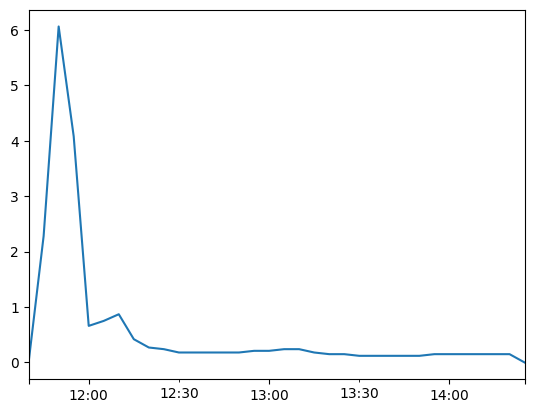

In [25]:
pevent.plot()

resample at 5min

Load the simulation

In [23]:
hill = Run.from_definition(root_dir+'SA_mil_1_CLM.pfidb')

 => Error during CLM import - CLM specific key have been skipped


Change simulation stoptime accordingly:

In [27]:
#hill.TimingInfo.StartTime = forc.index.get_loc(pevent.index[0])*5
#hill.TimingInfo.StopTime = forc.index.get_loc(pevent.index[-1])*5
#hill.TimingInfo.StartCount = forc.index.get_loc(pevent.index[0])
#hill.Solver.CLM.IstepStart = forc.index.get_loc(pevent.index[0])

delta_t = 4*30*24*12
#delta_t = 10*24*12

hill.TimingInfo.StartTime = (forc.index.get_loc(pevent.index[0])-delta_t)*5
hill.TimingInfo.StopTime = (forc.index.get_loc(pevent.index[-1])+10*24*12)*5
hill.TimingInfo.StartCount = (forc.index.get_loc(pevent.index[0])-delta_t)
hill.Solver.CLM.IstepStart = (forc.index.get_loc(pevent.index[0])-delta_t)


In [28]:
hill.TimingInfo.StartTime

645820

In [29]:
hill.TimingInfo.StartCount

129164

In [30]:
hill.TimingInfo.StopTime

833185

replace the cycle names and bc values: (recall to recompile parflow changing input_database.h)

In [31]:
hill.TimeStep.Value = 5
hill.TimingInfo.DumpInterval = 5
hill.Solver.Nonlinear.ResidualTol = 1e-12
hill.Solver.Nonlinear.MaxIter = 50
hill.Solver.CLM.CLMDumpInterval = -1
hill.Solver.PrintCLM = False
hill.Solver.CLM.ForceVegetation = True

Tester :

EvapBeta = linear ou cos
enlever sakaguchi


manning convert to minute

In [24]:
hill.Mannings.Geom.domain.Value = 0.0000056/60

In [25]:
hill.Mannings.Geom.domain.Value

9.333333333333334e-08

In [7]:
wdir = root_dir+'results2/'

In [28]:
if os.path.exists(wdir):
    shutil.rmtree(wdir)
os.mkdir(wdir)

In [29]:
shutil.copy(root_dir+'slopey.pfb',wdir+'slopey.pfb')
shutil.copy(root_dir+'perm1s.pfb',wdir+'perm1s.pfb')
shutil.copy(root_dir+'veg_map18.pfb',wdir+'veg_map.pfb')
#shutil.copy(root_dir+'veg_map19.pfb',wdir+'veg_map.pfb')

#shutil.copy(root_dir+'../data_2D/lai_2006_2009_5min.dat',wdir+'lai.dat')
#shutil.copy(root_dir+'../data_2D/sai_2006_2009_5min.dat',wdir+'sai.dat')
#shutil.copy(root_dir+'../data_2D/zom_2006_2009_5min.dat',wdir+'z0m.dat')
#shutil.copy(root_dir+'../data_2D/displa_2006_2009_5min.dat',wdir+'displa.dat')

shutil.copy(root_dir+'../data_2D/lai_2006_2009_5min_sn.dat',wdir+'lai.dat')
shutil.copy(root_dir+'../data_2D/sai_2006_2009_5min_sn.dat',wdir+'sai.dat')
shutil.copy(root_dir+'../data_2D/z0m_2006_2009_5min_sn.dat',wdir+'z0m.dat')
shutil.copy(root_dir+'../data_2D/displa_2006_2009_5min_sn.dat',wdir+'displa.dat')

shutil.copy(root_dir+'../data_2D/drv_vegm32_sn.dat',wdir+'drv_vegm.dat')
#shutil.copy(root_dir+'../data_2D/drv_vegm32_veg.dat',wdir+'drv_vegm.dat')

shutil.copy(root_dir+'../data_2D/drv_vegp_def.dat',wdir+'drv_vegp.dat')
shutil.copy(root_dir+'../data_2D/drv_clmin_def.dat',wdir+'drv_clmin.dat')
shutil.copy(root_dir+'forc_bani_5min_2006_2009.txt',wdir+'forcagePF.txt.0')



'/home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results2/forcagePF.txt.0'

In [30]:
hill.ComputationalGrid.NZ = 1
hill.dist(wdir+'slopey.pfb')
hill.dist(wdir+'veg_map.pfb')
hill.ComputationalGrid.NZ = 30
hill.dist(wdir+'perm1s.pfb')


In [31]:
hill.run(working_directory=wdir,skip_validation=False)


# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results2
# ParFlow database
#  - SA_mil_1_CLM.pfidb
# ==============================================================================

    CLM:
      CLMDumpInterval: -1 ✘
        ★ {'type': 'ERROR', 'message': 'Is smaller than min: 1'}
      WiltingPoint: -150.0 ✘
        ★ {'type': 'ERROR', 'message': 'Is smaller than min: 0.0'}
  TimingInfo:
    StartCount: 129164 ✘
      ★ {'type': 'ERROR', 'message': 'Is greater than max: 0'}

# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================



SystemExit: 1

/home/hectorb/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [32]:
def read_and_process_pf_outputs(wdir,date_start="2005-01-01",freq='h'):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.*.pfb')[0]) as s: h = s.header
    print(h)
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])
    var_dz_vec = var_dz[:,0,0]
    var_dz_vec = var_dz_vec[::-1]
    dz = var_dz_vec * h['dz']
    z = np.cumsum(dz) - dz* h['dz']/2 
    
    # get pressure (pop(0) skips initial condition)
    files = np.sort(glob.glob(wdir+'*.press.*.pfb'))[1::]
    press = read_pfb_sequence(files)
    
    # get saturation
    files = np.sort(glob.glob(wdir+'*.satur.*.pfb'))[1::]
    satur = read_pfb_sequence(files)
    
    # get overlandsum
    files = np.sort(glob.glob(wdir+'*.overlandsum.*.pfb'))
    overlandsum = read_pfb_sequence(files)
        
    # create dataset
    ds = xr.Dataset({"press": (("time","z","y"), press[:,::-1,:,0]),
                    "satur": (("time","z","y"), satur[:,::-1,:,0]),
                    "overlandsum":(("time","y"), overlandsum[:,0,:,0]),
                    'vdz': (("z","y"),var_dz[::-1,:,0])},
        coords={"x":np.arange(start = h['x'],stop = h['x']+h['nx']*h['dx'],step=h['dx']),
            "y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
            "z":-z, 
            "time": pd.date_range(date_start, periods=len(files),freq=freq),
            "reference_time": pd.Timestamp(date_start)})

    # add WTD:
    ds = ds.assign(WTD = z[-1] - ds.press.isel(z=-1))

    # add auxiliary variables:
    ds = ds.assign(poro=(("z","y"),read_pfb(glob.glob(wdir+'*poro*.pfb')[0])[::-1,:,0]))
    ds = ds.assign(specstor=(("z","y"),read_pfb(glob.glob(wdir+'*specific*.pfb')[0])[::-1,:,0]))    
    ds = ds.assign(alpha=(("z","y"),read_pfb(glob.glob(wdir+'*alpha*.pfb')[0])[::-1,:,0]))    
    ds = ds.assign(n=(("z","y"),read_pfb(glob.glob(wdir+'*.out.n.pfb')[0])[::-1,:,0]))    
    ds = ds.assign(Ks=(("z","y"),read_pfb(glob.glob(wdir+'*.out.perm_x.pfb')[0])[::-1,:,0]))    
    ds = ds.assign(sres=(("z","y"),read_pfb(glob.glob(wdir+'*.out.sres.pfb')[0])[::-1,:,0]))    
    ds = ds.assign(ssat=(("z","y"),read_pfb(glob.glob(wdir+'*.out.ssat.pfb')[0])[::-1,:,0]))    

    # compute storage:
    ds = ds.assign(storage_cbyc=lambda x: h['dx']*h['dy']*h['dz']*x.satur*x.vdz*x.poro + \
                                        h['dx']*h['dy']*h['dz']*x.vdz*x.specstor*x.satur*x.press + \
                                        xr.where((x.z==x.z[0]) & (x.press>0),h['dx']*h['dy']*x.press,0))
    ds = ds.assign(storage=lambda x: x.storage_cbyc.sum(dim=('z')))

    ds = ds.assign(soil_moisture = lambda x: x.satur*x.poro)
    
    ds.press.attrs['units']='m'
    ds.satur.attrs['units']='m3/m3'
    ds.overlandsum.attrs['units']='m3/PFtimestep' 
    ds.storage.attrs['units']='m3'
    ds.storage_cbyc.attrs['units']='m3'  
    ds.alpha.attrs['units']='1/m'
    ds.n.attrs['units']='-'    
    ds.Ks.attrs['units']='m/min'
    ds.y.attrs['units']='meters'
    ds.z.attrs['units']='meters'
    return ds

In [33]:
#ds1 = read_and_process_pf_outputs(wdir,date_start=pevent.index[0],freq='5min')
ds1 = read_and_process_pf_outputs(wdir,date_start=forc.index[forc.index.get_loc(pevent.index[0])-delta_t],freq='5min')


with ParflowBinaryReader(glob.glob(wdir+'*.press.*.pfb')[0]) as s: h = s.header
h['dx']

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


100.0

In [34]:
ds1 = ds1.assign(slopex=(("y"),read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])[0,:,0]))
ds1 = ds1.assign(slopey=(("y"),read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])[0,:,0]))
ds1 = ds1.assign(mask=(("z","y","x"),read_pfb(glob.glob(wdir+'*mask*.pfb')[0])))

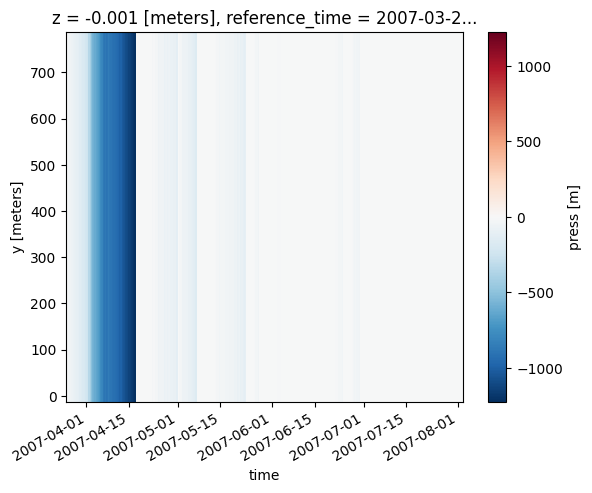

In [35]:
ds1.press.isel(z=0).plot(x='time')

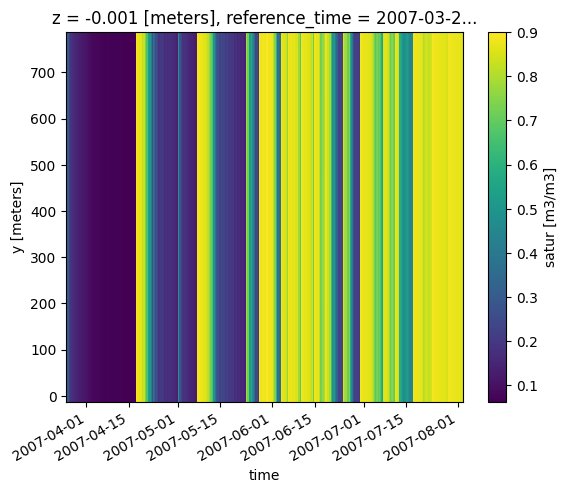

In [85]:
ds1.satur.isel(z=0).plot(x='time')

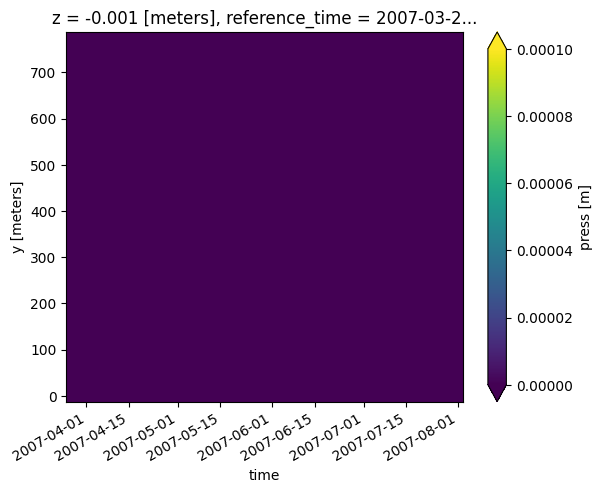

In [36]:
ds1.press.isel(z=0).plot(x='time',vmax=0.0001,vmin =0)

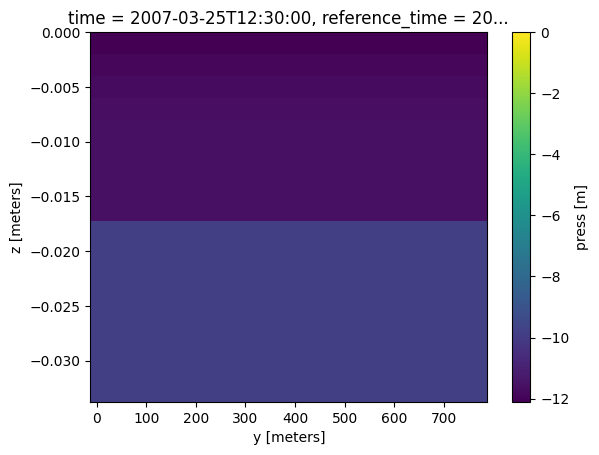

In [37]:
(ds1.press.isel(time=10)).isel(z=[i for i in range(6)]).plot(x='y',vmax=0)

In [38]:
Dds1 = ds1.press.differentiate(coord="z")

In [39]:
(ds1.press.isel(y=8)).isel(z=[i for i in range(6)]).isel(time=10)

<xarray.DataArray 'press' (z: 6)>
array([-12.10133489, -11.89010997, -11.73861945, -11.64002446,
       -11.59048406,  -9.86650016])
Coordinates:
    y               float64 200.0
  * z               (z) float64 -0.001 -0.003 -0.005 -0.007 -0.009 -0.0255
    time            datetime64[ns] 2007-03-25T12:30:00
    reference_time  datetime64[ns] 2007-03-25T11:40:00
Attributes:
    units:    m

In [40]:
(Dds1.isel(y=8)).isel(z=[i for i in range(6)]).isel(time=10)

<xarray.DataArray 'press' (z: 6)>
array([-105.61246094,  -90.67885992,  -62.5213761 ,  -37.03384705,
        -33.38789509,  -68.53684521])
Coordinates:
    y               float64 200.0
  * z               (z) float64 -0.001 -0.003 -0.005 -0.007 -0.009 -0.0255
    time            datetime64[ns] 2007-03-25T12:30:00
    reference_time  datetime64[ns] 2007-03-25T11:40:00

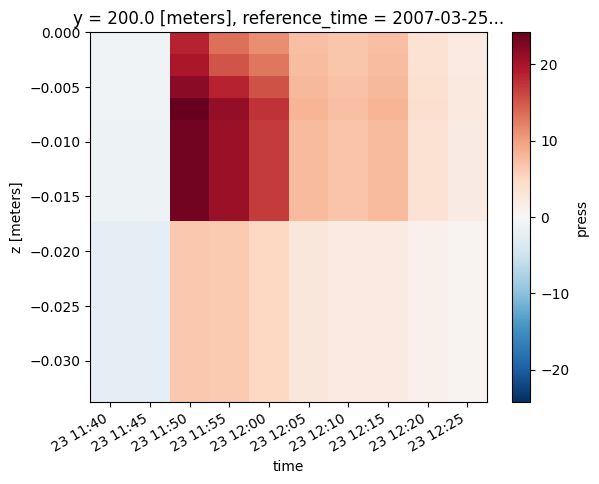

In [41]:
(Dds1.isel(y=8)).isel(z=[i for i in range(6)]).sel(time=pevent.index[0:10]).plot(x='time')

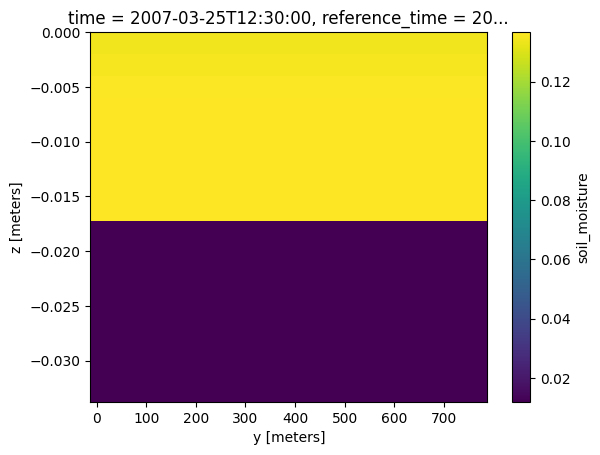

In [42]:
(ds1.soil_moisture.isel(time=10)).isel(z=[i for i in range(6)]).plot(x='y')

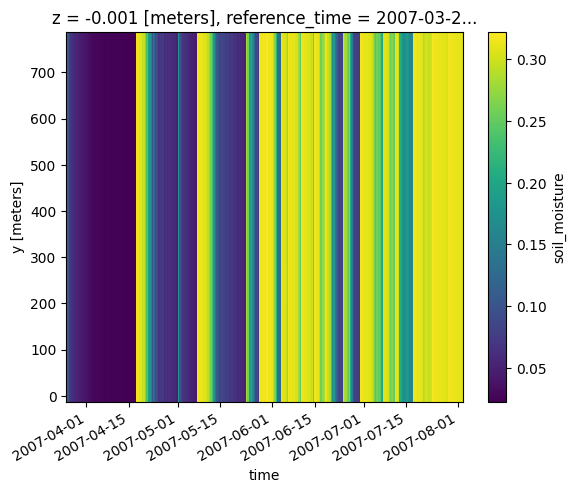

In [43]:
ds1.soil_moisture.isel(z=0).plot(x='time')

In [44]:
SM_uphill = ds1.soil_moisture.isel(y=-1).to_dataframe(dim_order=['time','z']).iloc[:,-1].unstack(1)
SM_downhill = ds1.soil_moisture.isel(y=3).to_dataframe(dim_order=['time','z']).iloc[:,-1].unstack(1)

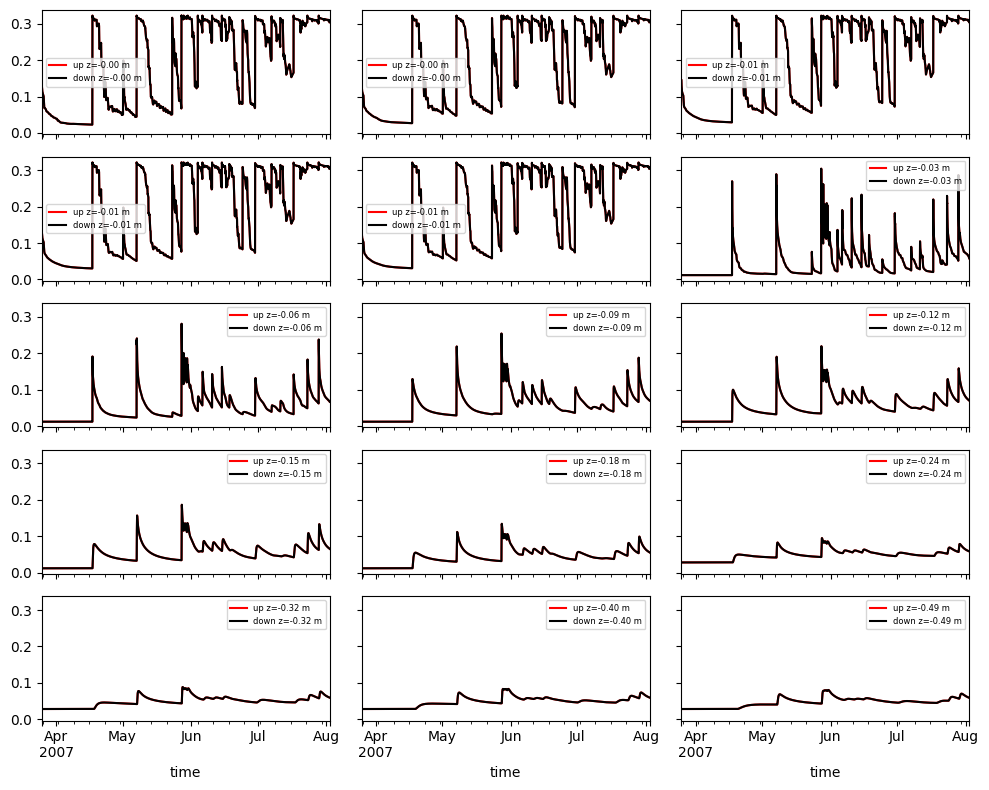

In [45]:
import calendar
fig, axes = plt.subplots(5,3,figsize=(10,8),squeeze=True,sharex=True,sharey=True)
for i,ax in enumerate(axes.flatten()):
    SM_uphill.iloc[:,i].plot(ax=ax,color='r',label = 'up z=%2.2f m'%float(SM_uphill.columns[i]))
    SM_downhill.iloc[:,i].plot(ax=ax,color='k',label = 'down z=%2.2f m'%float(SM_downhill.columns[i]))
    ax.legend(fontsize=6)
plt.tight_layout()

In [46]:
def calculate_OVFLOW(width,manning,slope,h):
    """
    simple function which return the overland flux from one cell to another across one cell
    """
    return (width/manning)*(slope**0.5)*h**(5./3.)


def calculate_runoff_from_press(htop,slopex,slopey,dx,dy,m):
    """
    compute runoff at single location
    htop dim is time
    """
    Sy = np.abs(slopey)
    Sx = np.abs(slopex)
    return np.where(htop>0,np.abs(calculate_OVFLOW(dy,m,Sx,htop))+np.abs(calculate_OVFLOW(dx,m,Sy,htop)),0)


In [47]:
manning = hill.Mannings.Geom.domain.Value
ds1 = ds1.assign(Q=lambda x: ('time',calculate_runoff_from_press(x.press.data[:,0,0],
                                                         x.slopex.data[0],
                                                         x.slopey.data[0],
                                                         h['dx'],h['dy'],manning)))
ds1.Q.attrs['units']='m3/timestep'
ds1 = ds1.assign(Qmm = lambda x: x.Q/h['dx']/h['nx']/h['dy']/h['ny']*1000)

/tmp/ipykernel_83278/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


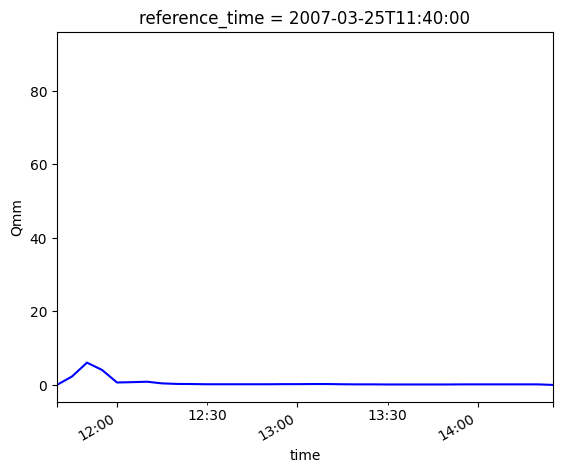

In [48]:
fig, ax = plt.subplots(1,1)
pevent.plot(ax=ax,color='b')
ds1.Qmm.plot(ax=ax,color = 'k')


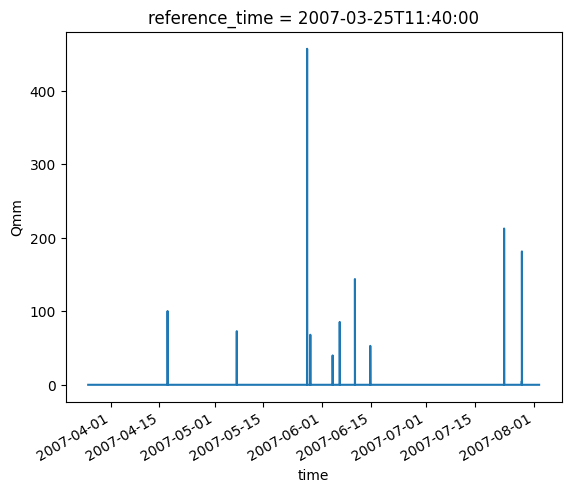

In [49]:
(ds1.Qmm*5).plot()

In [50]:
Ke = 100*(ds1.Qmm*5).sum()/vol
print("Ke = %2.2f %%"%Ke)

Ke = 17806.40 %


In [51]:
#lame d'eau
(ds1.Qmm*5).sum()

<xarray.DataArray 'Qmm' ()>
array(3456.22245107)
Coordinates:
    reference_time  datetime64[ns] 2007-03-25T11:40:00

In [52]:
storage = ds1.storage.sum(dim='y').to_dataframe()['storage']*1000/h['dx']/h['dy']/h['ny']
storage = storage - storage[0]

In [53]:
storage

time
2007-03-25 11:40:00       0.000000
2007-03-25 11:45:00      14.530496
2007-03-25 11:50:00      26.969311
2007-03-25 11:55:00      37.822175
2007-03-25 12:00:00      47.466014
                          ...     
2007-08-02 14:00:00    1808.211289
2007-08-02 14:05:00    1808.210277
2007-08-02 14:10:00    1808.209264
2007-08-02 14:15:00    1808.208249
2007-08-02 14:20:00    1808.207234
Freq: 5T, Name: storage, Length: 37473, dtype: float64

In [54]:
ds1.y

<xarray.DataArray 'y' (y: 32)>
array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250., 275.,
       300., 325., 350., 375., 400., 425., 450., 475., 500., 525., 550., 575.,
       600., 625., 650., 675., 700., 725., 750., 775.])
Coordinates:
  * y               (y) float64 0.0 25.0 50.0 75.0 ... 700.0 725.0 750.0 775.0
    reference_time  datetime64[ns] 2007-03-25T11:40:00
Attributes:
    units:    meters

In [55]:
def calc_cond_h(h,Ks,alpha,n):
    """
    """
    h2= xr.where(h<=0,0,h)
    m=1-1/n
    return Ks*((1-((h2*alpha)**(n-1))/((1+(h2*alpha)**n)**m))**2)/((1+(h2*alpha)**n)**(m/2))

def calc_retention(h,thr,ths,hg,n):
    """
    """
    return thr+(ths-thr)*(1+(h/hg)**n)**(-(1-1/n))

def calc_cond_theta(theta,thetar,thetas,n):
    """
    seems not to work
    """
    m=1-2/n
    T = (theta - thetar)/(thetas - thetar)
    return (T**2)*(1-(1-T**(1/m))**m)

In [56]:
ds1 = ds1.assign(K_h=lambda x: calc_cond_h(-x.press,x.Ks*60,x.alpha,x.n))
#ds1 = ds1.assign(K_theta=lambda x: calc_cond_theta(x.satur*x.poro,x.sres*x.poro,x.ssat*x.poro,x.n))

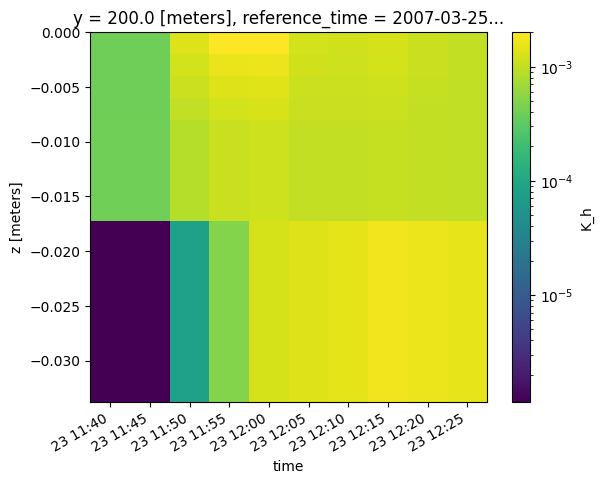

In [57]:
import matplotlib.colors as colors
(ds1.K_h.isel(y=8)).isel(z=[i for i in range(6)]).sel(time=pevent.index[0:10]).plot(x='time',norm=colors.LogNorm())
#(ds1.K_h.isel(y=8)).isel(z=[i for i in range(6)]).sel(time=pevent.index[0:10]).plot(x='time')

In [58]:
ds1 = ds1.assign(Fz = lambda x: x.K_h*x.press.differentiate(coord="z"))

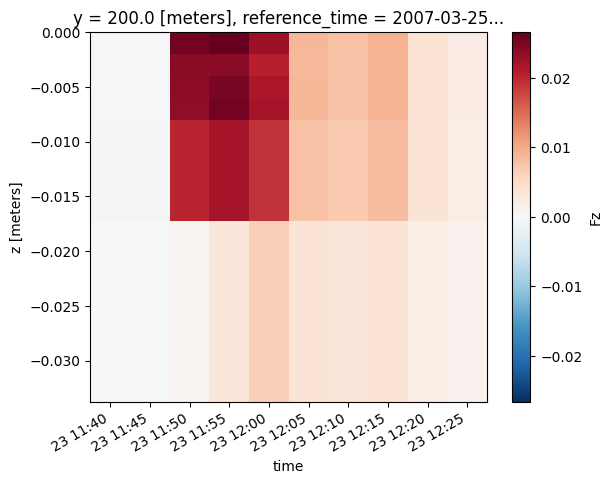

In [59]:
import matplotlib.colors as colors
(ds1.Fz.isel(y=8)).isel(z=[i for i in range(6)]).sel(time=pevent.index[0:10]).plot(x='time')
#(ds1.K_h.isel(y=8)).isel(z=[i for i in range(6)]).sel(time=pevent.index[0:10]).plot(x='time')

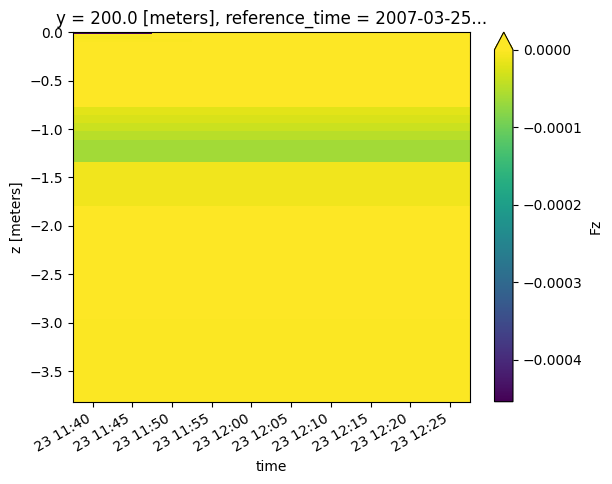

In [72]:
(ds1.Fz.isel(y=8)).isel(z=[i for i in range(27)]).sel(time=pevent.index[0:10]).plot(x='time',vmax=0)

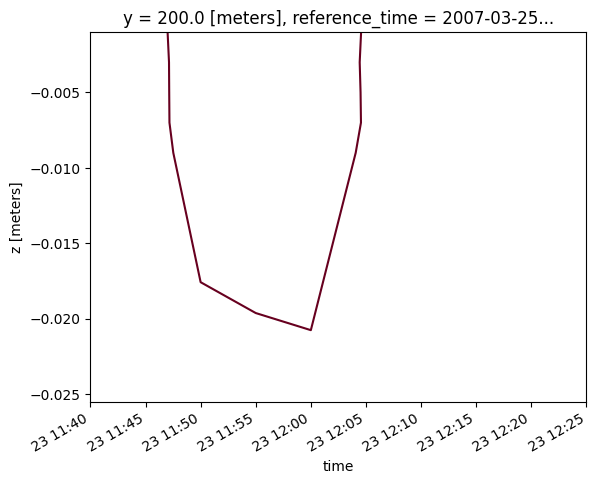

In [61]:
(ds1.Fz.isel(y=8)).isel(z=[i for i in range(6)]).sel(time=pevent.index[0:10]).plot.contour(x='time',levels=np.linspace(-0.01, 0.01,2))

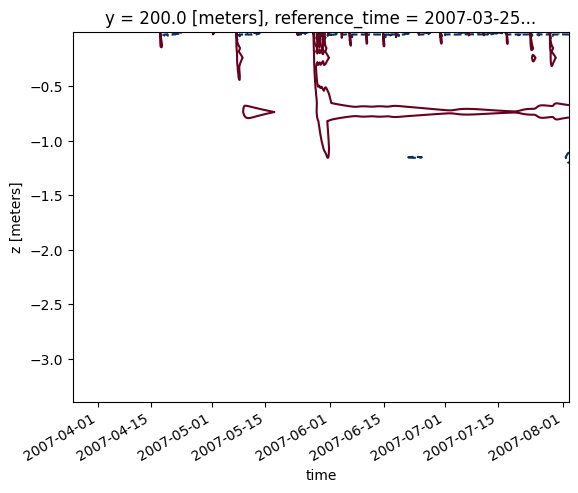

In [62]:
(ds1.Fz.isel(y=8)).isel(z=[i for i in range(27)]).plot.contour(x='time',levels=np.linspace(-0.0001, 0.0001,2))

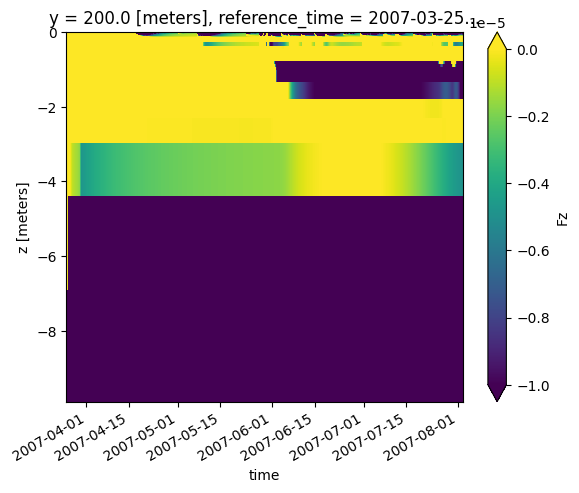

In [63]:
(ds1.Fz.isel(y=8)).isel(z=[i for i in range(29)]).plot(x='time',vmin=-0.00001,vmax=0.0)

In [77]:
ds1.z[24]

<xarray.DataArray 'z' ()>
array(-2.042)
Coordinates:
    z               float64 -2.042
    reference_time  datetime64[ns] 2007-03-25T11:40:00
Attributes:
    units:    meters

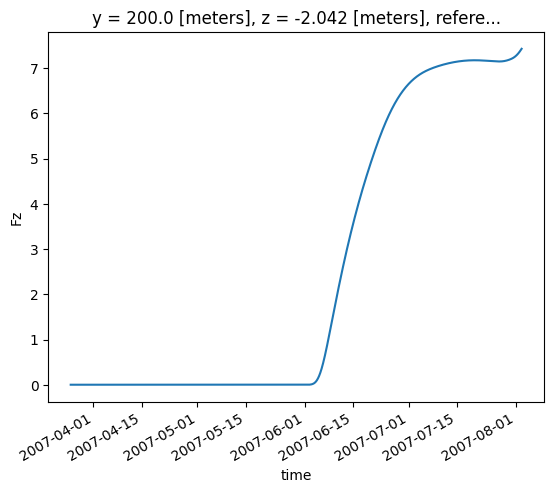

In [84]:
(ds1.Fz.isel(y=8).isel(z=24)/12*1000).cumsum().plot()

100.0

In [215]:
tmp = ds1.isel(y=8).isel(z=[i for i in range(6)]).to_dataframe().loc[:,['press','K_h']]

In [216]:
tmp.dropna(how='any')

press           K_h
time                z       x                           
2007-03-25 11:40:00 -0.0010 0.0 -10.779323  8.297264e-07
                    -0.0030 0.0 -10.394684  9.279071e-07
                    -0.0050 0.0 -10.188904  9.866713e-07
                    -0.0070 0.0 -10.081058  1.019405e-06
                    -0.0090 0.0 -10.033644  1.034243e-06
...                                    ...           ...
2007-08-02 14:20:00 -0.0030 0.0  -0.579516  4.632015e-04
                    -0.0050 0.0  -0.577495  4.647309e-04
                    -0.0070 0.0  -0.575465  4.662734e-04
                    -0.0090 0.0  -0.573427  4.678290e-04
                    -0.0255 0.0  -0.514813  5.295738e-06

[224838 rows x 2 columns]

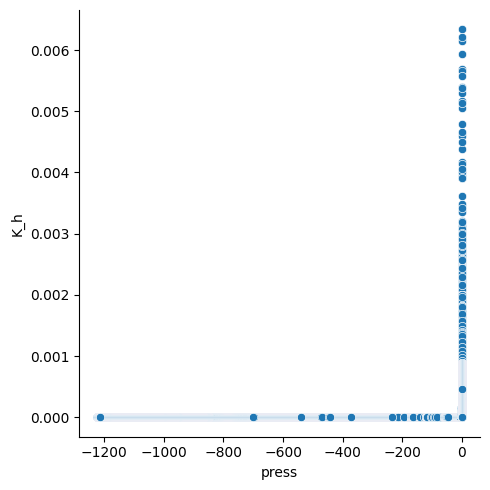

In [217]:
pl = sns.relplot(x='press',y='K_h',data=tmp)


/home/hectorb/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:38: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(**kwargs)
/home/hectorb/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:38: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(**kwargs)


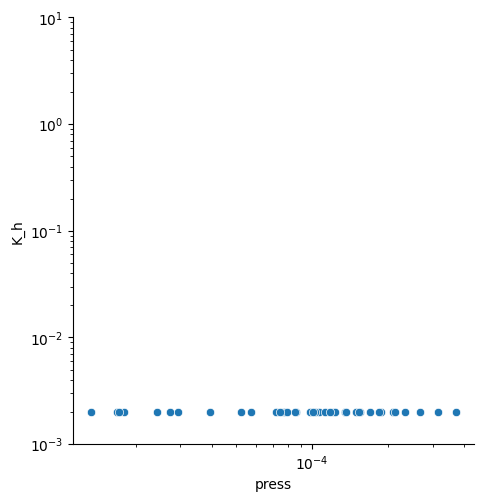

In [218]:
pl = sns.relplot(x='press',y='K_h',data=tmp.dropna(how='any'))
pl.set(xscale="log")
pl.set(yscale="log")
pl.set(xlim=(-1000,0))
pl.set(ylim=(0.001,10))

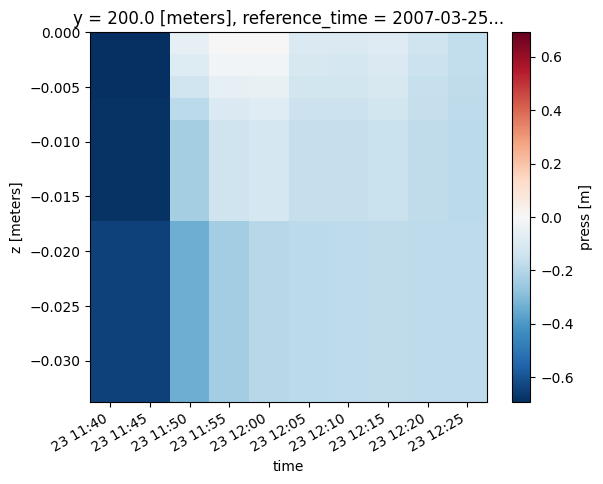

In [180]:
(ds1.press.isel(y=8)).isel(z=[i for i in range(6)]).sel(time=pevent.index[0:10]).plot(x='time')

In [181]:
(ds1.K_h.isel(y=8)).isel(z=[i for i in range(6)]).sel(time=pevent.index[0:10])

<xarray.DataArray 'K_h' (z: 6, time: 10)>
array([[       nan,        nan,        nan, 0.00191455, 0.00192707,
               nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [0.00967717, 0.00967725, 0.00990973, 0.00995485, 0.00997026,
        0.00997191, 0.00997319, 0.00997536, 0.00997458, 0.00997327]])
Coordinates:
    y               float64 200.0
  * z               (z) float64 -0.001 -0.003 -0.005 -0.007 -0.009 -0.0255
  * time            (time) datetime64[ns] 2007-07-23T11:40:00 ... 2007-07-23T...
    reference_time  datetime64[ns] 2007-03-25T11:40:00